# 1.この課題の目的
アンサンブル学習について理解する
EDAをするだけでなく、適切にEDAの分析結果を使えるようにする

今回のkaggle マルウエア
https://www.kaggle.com/c/microsoft-malware-prediction

# 問題１
評価指標

このコンペの評価指標はAUCと呼ばれるROC曲線の面積になります。ここでは復習も兼ねて、以下の点を意識しながら調査し、notebookに記述してください。

- なぜ閾値が存在するのか？

- ROC曲線の縦軸と横軸は何を意味するか？

- ROC曲線はどのような形状が理想的だと言えるか？

- 機械学習における、分類タスクの指標には他にもMCC（マシューズ相関係数）があります。

- MCCについて他の指標と比較しながら説明してください。（主にどのような場面で発揮する評価指標か、F1スコアとの違いなど）



 ## AUC, ROC曲線

False Positive Rate（偽陽性率）を横軸にTrue Positive Rate（真陽性率）を縦軸に置いてプロットしたものがROC曲線です。

閾値を大きい値から下げていくと、偽陽性率と真陽性率がともに大きくなっていく。

閾値を下げるということは、なんでもかんでもとりあえずpositiveと予測することを指しているので、陽性と判定される割合は大きくなる(真陽性率が大きくなる）と同時に、間違って陽性と判定する割合(偽陽性率が大きくなる）も高くなります。

目指したいのは、間違って陽性と判定する割合を小さくして(偽陽性率が小さい）、なおかつ正解データの陽性であるものをできるだけ多く陽性と判定(真陽性率が大きい）できるモデルを作ることです。

閾値を変化させたときの偽陽性率と真陽性率による各点を結んだものがROC曲線です。

偽陽性率が低い時点で既に真陽性率が高い数値になるような、ROC曲線が理想的。


## マシューズ相関係数

マシューズ相関係数とはMCC（Matthews Correlation Coefficient）と言われて、２値分類モデルの精度をみる指標です。真陽性と陰陰陽性と陰性を考慮し、クラスが非常に異なるサイズであっても使用できるバランスの取れた尺度と一般的にみなされます。MCCは、本質的に、- 1と+1との間の相関係数値である。 + 1の係数は完全予測を表し、0は平均ランダム予測を表し、-1は逆予測を表す。

不均衡データの場合かつ陽性のラベルが多い方のラベルの場合、常に陽性のラベルを予測することで、accracy, Precision, recall, F1スコアが常に高く出てしまうことになる。そこでマシューズ相関係数を使うことで適正な評価ができる。また陽性がどちらのラベルか気にしなくて良い。

# 問題2
EDA

仮説を立てて（予測をして）から始めましょう。仮説を立てるにはある程度のドメインの勉強は必要です。分野に詳しくなければ特徴量について検索しましょう。今回は出力するグラフの個数に制限はありません。

その代わり、一つ一つの分析に根拠をもち、得られた結果についてそのグラフが何を意味しているのかをしっかり述べてください。

以下に仮説、EDAの例を示します。

仮説の例

osは重要そう。定期的にosを更新しているかどうかなど。
国も重要そう。日本や中国などネットのインフラが整っているほどマルウェア感染リスクは、高まりそう。
Hastpmも重要そう。マザーボードにつけられているセキュリティ対策用のチップ。https://docs.microsoft.com/ja-jp/windows/security/information-protection/tpm/how-windows-uses-the-tpm



firewallも重要そう。だが直接的にはマルウェアとは関係ない。
https://it-trend.jp/firewall/article/firewallcannot

EDAのフロー例1

以上の仮説から、OSver、 firewall、　Hastpm 、 Isprotected、　IsBata、 CountryIDを特徴量として選択する。
trainデータの各特徴量の欠損比率を確認する。
欠損の割合から欠損は補完せずに削除する。
モデルを決定木として学習させる。

説明

My EDA - I want to see all! | Kaggle https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all

上記のカーネルはこのコンペにおいて最も参考にされているカーネルのうちの１つです。このカーネルの3. Correlationsの部分で明らかに不自然なところがあります。不自然な点とその理由を答えてください。

### 不自然な点は、分類なのにターゲットと相関をとっても意味ない点。

 ### 仮説は、パソコンの使用頻度が低いほど感染しにくいのでは→しょぼいパソコン使っていると感染率低そう
 →　gamepc使ってない人は感染率低い？
 
 →　osが古い人は感染率低い？
 
 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

/Users/morio/.pyenv/versions/anaconda3-5.3.0/envs/python-ml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import sys
sys.path.append("/Users/morio/diveintocode-ml/ml-scratch")
from utils.pipyline_R import Pipyline_R

In [20]:
#ProductName - 防御側の状態情報
def plot_category_percent_of_target(col):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cat_percent = train_small[[col, 'HasDetections']].groupby(col, as_index=False).mean()
    cat_size = train_small[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['HasDetections'] = cat_percent['HasDetections'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='HasDetections', y=col, data=cat_percent, order=cat_percent[col])

    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    plt.xlabel('% of HasDetections(target)')
    plt.ylabel(col)
    plt.show()

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%time train = pd.read_csv("/Users/morio/diveintocode-ml/input/microsoft/train.csv", dtype=dtypes)
%time test = pd.read_csv("/Users/morio/diveintocode-ml/input/microsoft/test.csv", dtype=dtypes)

CPU times: user 3min 42s, sys: 15.7 s, total: 3min 58s
Wall time: 4min 7s
CPU times: user 3min 34s, sys: 18 s, total: 3min 52s
Wall time: 4min 3s


In [7]:
print(train.shape, test.shape)

(8921483, 83) (7853253, 82)


Text(0.5, 1.0, 'HasDetections(target)')

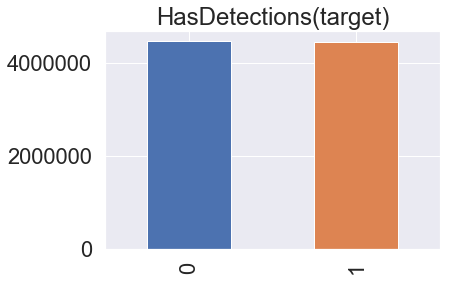

In [6]:
train['HasDetections'].value_counts().plot.bar()
plt.title('HasDetections(target)')

均衡しているデータである

In [20]:
%%time
# checking missing data
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

CPU times: user 54.9 s, sys: 24.7 s, total: 1min 19s
Wall time: 1min 32s


In [21]:
missing_train_data.head(50)

,Total,Percent
PuaMode,8919174,99.974107
Census_ProcessorClass,8884852,99.589407
DefaultBrowsersIdentifier,8488045,95.141637
Census_IsFlightingInternal,7408759,83.044030
Census_InternalBatteryType,6338429,71.046809
Census_ThresholdOptIn,5667325,63.524472
Census_IsWIMBootEnabled,5659703,63.439038
SmartScreen,3177011,35.610795
OrganizationIdentifier,2751518,30.841487
SMode,537759,6.027686


PuaMode, Census_ProcessorClass, DefaultBrowsersIdentifier, Census_IsFlightingInternal and Census_InternalBatteryType
の欠損率が７０パーセントを超えている

ターゲットに関してそれらの分布をチェックしましょう

データセットは大きいので、10％のトレインを使用して分布を比較しましょう

In [8]:
train_small = train.sample(frac=0.2).copy()

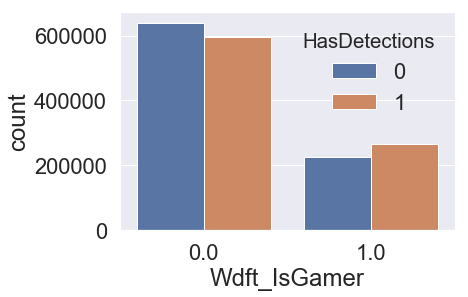

In [16]:
sns.countplot(x='Wdft_IsGamer', hue='HasDetections',data=train_small)

ゲーム用pcかどうか。

仮説通り、ゲームpcではない人の方が感染率が低い。

In [83]:
train_small[train_small["Platform"] == "windows8"].shape[0] / train_small.shape[0]

0.021873040194541605

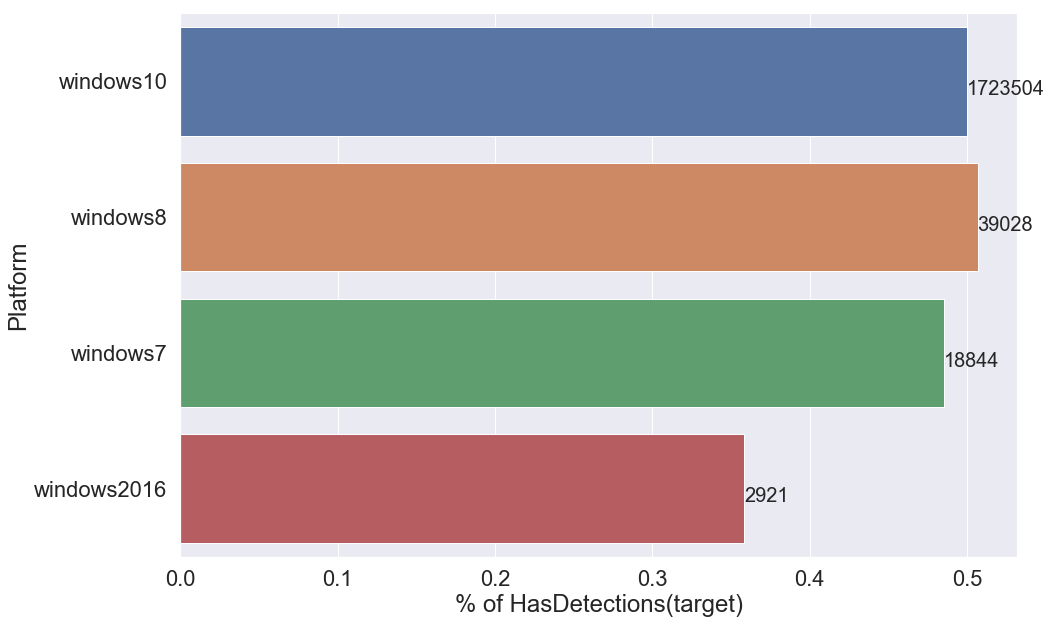

In [37]:
plot_category_percent_of_target("Platform")

In [62]:
#train_small["CountryIdentifier"].value_counts()
a = train_small[train_small["Platform"] == "windows8"]["CountryIdentifier"].value_counts() / train_small["CountryIdentifier"].value_counts() *100

In [77]:
#コンゴの感染率
train_small[train_small["HasDetections"] == 1][train_small['CountryIdentifier'] == 201].shape[0]  / train_small[train_small['CountryIdentifier'] == 201].shape[0]

0.5058868988089826

In [79]:
#コンゴのウィンドウズ８の感染率
train_small[train_small["HasDetections"] == 1][train_small["CountryIdentifier"] == 201][train_small["Platform"] == "windows8"].shape[0] / train_small[train_small["CountryIdentifier"] == 201][train_small["Platform"] == "windows8"].shape[0]

0.5518427518427519

In [84]:
b = train_small[train_small["HasDetections"] == 1]["CountryIdentifier"].value_counts() / train_small["CountryIdentifier"].value_counts() *100

In [96]:
#国ごとの感染率
b.sort_values(ascending=False)

1      47.524752
2      46.673787
3      51.550802
4      40.928270
5      50.537634
6      47.546451
7      56.362355
8      48.821414
9      50.770794
10     40.000000
11     44.339116
12     45.227119
13     38.786765
14     27.722772
15     50.343474
16     47.047739
17     41.792295
18     52.724456
19     44.759100
20     51.700680
21     55.492532
22     44.494892
23     60.621762
24     55.612245
25     25.555556
26     50.352609
27     60.209963
28     33.644860
29     50.499285
30     40.778839
         ...    
193    44.186047
194    53.571429
195    55.059253
196    58.333333
197    52.830189
198    57.446809
199    46.406367
200    58.227848
201    50.588690
202    44.063927
203    49.770388
204    46.214745
205    52.306509
206    46.099912
207    48.785531
208    45.928403
209    51.193634
210    44.051447
211    50.993300
212    49.090909
213    19.834711
214    60.694703
215    53.271028
216    37.681159
217    42.857143
218    57.003257
219    32.075472
220    46.7292

In [63]:
a.sort_values(ascending=False)

201    4.625420
101    4.297551
207    3.667174
93     3.624434
29     3.447783
141    3.178536
107    3.103869
160    2.851169
171    2.776496
35     2.701928
44     2.678816
155    2.660724
66     2.646790
68     2.631414
56     2.628475
41     2.624902
203    2.425970
178    2.411103
159    2.406081
2      2.395484
161    2.380952
152    2.365309
60     2.364245
43     2.320291
51     2.306492
142    2.302644
19     2.295726
110    2.269873
12     2.237384
15     2.158979
         ...   
157    0.303030
125    0.294118
139    0.271003
20     0.170068
218    0.162866
5           NaN
10          NaN
14          NaN
31          NaN
37          NaN
38          NaN
64          NaN
75          NaN
114         NaN
126         NaN
128         NaN
146         NaN
165         NaN
174         NaN
175         NaN
186         NaN
187         NaN
191         NaN
192         NaN
193         NaN
198         NaN
200         NaN
215         NaN
216         NaN
217         NaN
Name: CountryIdentifier,

ほとんどがwindows10のデータであることがわかる。

７と２０１６の感染率が低いが、windows8の感染率の高さが謎。

windows８の使用率が高い国

コンゴ　アフリカ

ガイアナ　　南米

セントクリストファーネイビス　カリブ

グリーンランド　

ベラルーシ　バルト三国の東

リトアニア　バルト三国　

モーリシャス　マダガスカルの東の島

コンゴのウィンドウズ８の感染率が５５パーセントとかなり高かった。他は見てません。

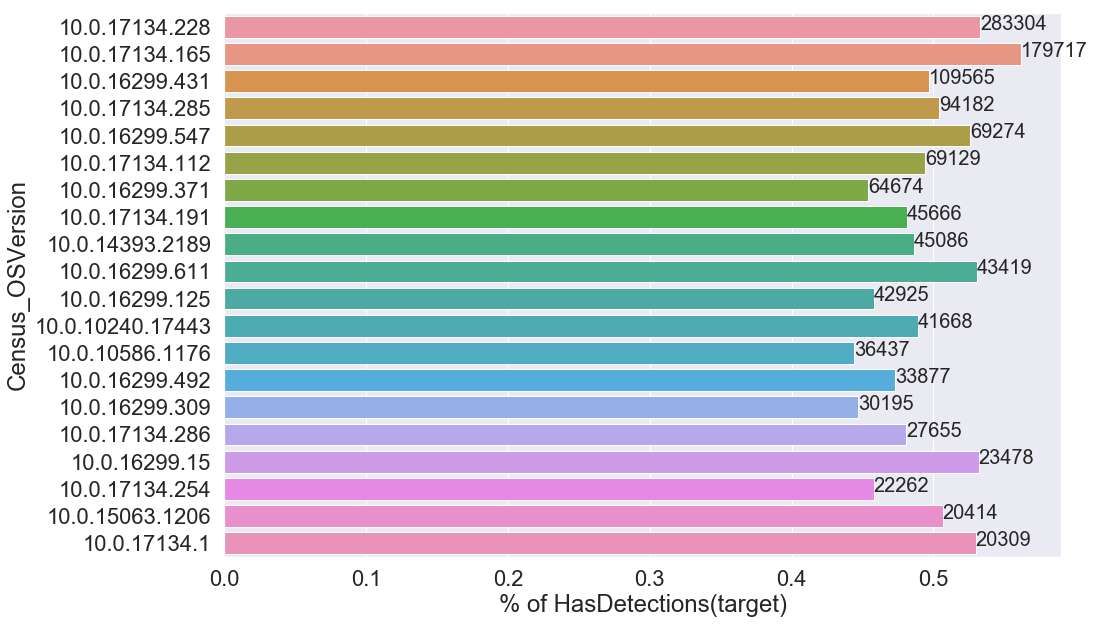

In [22]:
plot_category_percent_of_target("Census_OSVersion")

osのバージョン　なんで１０しかないなのかわからない？？

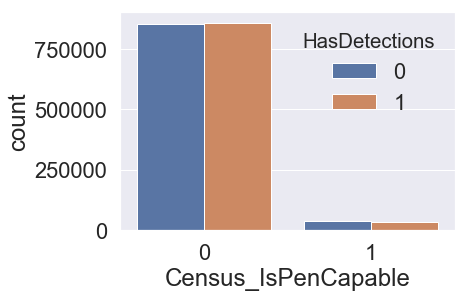

In [30]:
sns.countplot(x='Census_IsPenCapable', hue='HasDetections',data=train_small)
plt.show()

ペン入力に対応しているデバイスかどうか。タッチパネル？？

対応してる方が感染しなそうだが、わずかに対応してないほうが感染率が高い。不均衡すぎてあまりわからない。

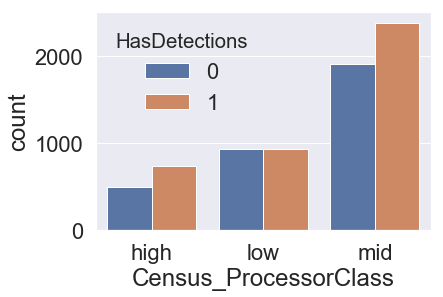

In [80]:
sns.countplot(x='Census_ProcessorClass', hue='HasDetections',data=train_small)
plt.show()

「Census_ProcessorClassr」の意味は、「プロセッサ内の論理コア数」です。

論理コアが多いほど、マルウェアに感染している可能性が高い。

仮説ともあっている。

## こっからカーネルうつし

In [9]:
#PuaMode  pua=不要と思われるアプリケーション？
print(train_small['PuaMode'].dtypes)

category


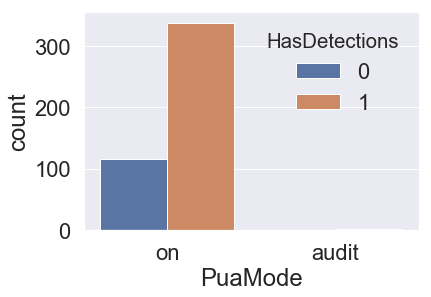

In [24]:
sns.countplot(x='PuaMode', hue='HasDetections',data=train_small)
plt.show()

差はあるが、サンプルは非常に少ないので、この機能を削除する

In [25]:
#Census_ProcessorClass　
#「Census_ProcessorClassr」の意味は、「プロセッサ内の論理コア数」です。
print(train_small['Census_ProcessorClass'].dtypes)

category


float16


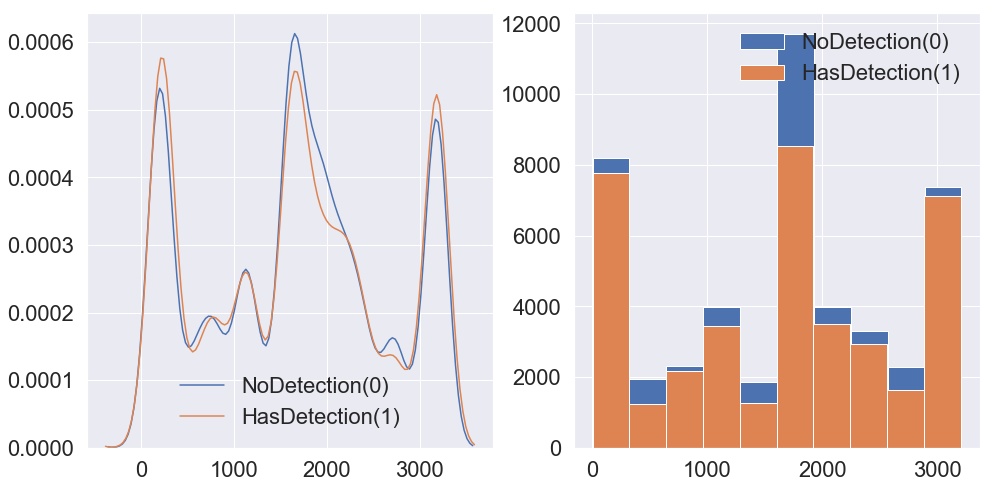

In [27]:
#DefaultBrosersIdentifier
print(train_small['DefaultBrowsersIdentifier'].dtypes)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(train_small.loc[train['HasDetections'] == 0, 'DefaultBrowsersIdentifier'], ax=ax[0], label='NoDetection(0)')
sns.kdeplot(train_small.loc[train['HasDetections'] == 1, 'DefaultBrowsersIdentifier'], ax=ax[0], label='HasDetection(1)')

train_small.loc[train['HasDetections'] == 0, 'DefaultBrowsersIdentifier'].hist(ax=ax[1])
train_small.loc[train['HasDetections'] == 1, 'DefaultBrowsersIdentifier'].hist(ax=ax[1])
ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])

plt.show()

DefaultBrowsersIdentifierは、「マシンのデフォルトブラウザのID」を意味します。

この機能は意味がありますか？ なさそうです

float16


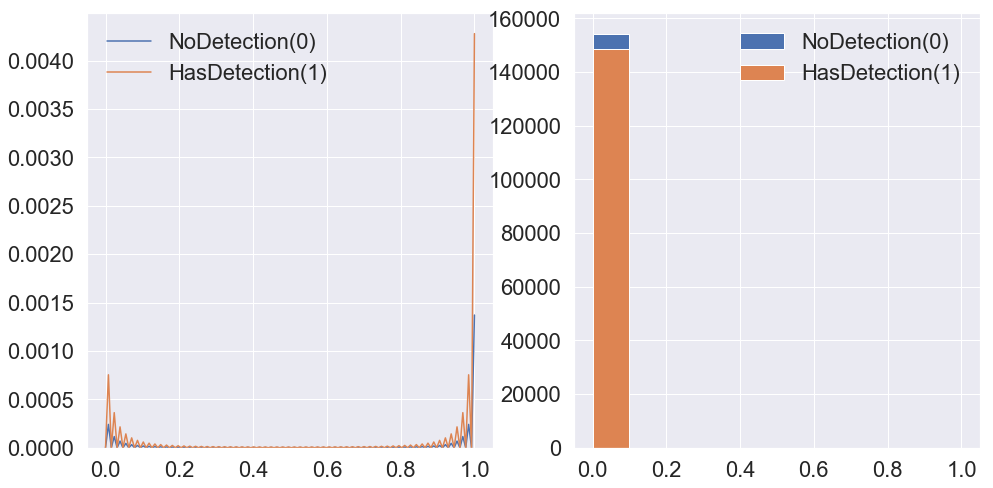

In [29]:
#Census_IsFightingInternal¶
print(train_small['Census_IsFlightingInternal'].dtypes)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(train_small.loc[train_small['HasDetections'] == 0, 'Census_IsFlightingInternal'], ax=ax[0], label='NoDetection(0)')
sns.kdeplot(train_small.loc[train_small['HasDetections'] == 1, 'Census_IsFlightingInternal'], ax=ax[0], label='HasDetection(1)')

train_small.loc[train['HasDetections'] == 0, 'Census_IsFlightingInternal'].hist(ax=ax[1])
train_small.loc[train['HasDetections'] == 1, 'Census_IsFlightingInternal'].hist(ax=ax[1])
ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])

plt.show()

ご覧のとおり、 'Census_IsFlightingInternal'のほとんどの値は0.0です。ただ削除してください。

In [30]:
#Census_InternalBatteryType
print(train_small['Census_InternalBatteryType'].dtypes)
train_small['Census_InternalBatteryType'].value_counts()

category


lion        405159
li-i         49185
#            37129
lip          12447
liio          6397
li p          1704
li            1260
nimh           925
real           558
pbac           495
bq20           435
vbox           308
unkn           108
lgi0            78
lipo            41
lhp0            33
4cel            31
lipp            17
batt            14
ithi            12
virt             5
pad0             4
ots0             4
lai0             3
a132             2
lio              2
ÿÿÿÿ             2
ca48             2
ram              2
lit              2
             ...  
lio             0
l&#TAB#         0
#TAB#            0
8                0
ip              0
sams             0
li              0
3500             0
6ion             0
li-h             0
a138             0
pbso             0
li?              0
lp               0
@i             0
li-l             0
lgl0             0
2337             0
a130             0
icp3             0
p-sn             0
sail        

この機能は各マシンの電池の種類を意味すると思います。

最近、ほとんどの電池はリチウムイオン電池です。

それでは、それらをリチウム電池グループと非リチウム電池グループに分類しましょう。

In [32]:
def group_battery(x):
    x = x.lower()
    if 'li' in x:
        return 1
    else:
        return 0
    
train_small['Census_InternalBatteryType'] = train_small['Census_InternalBatteryType'].apply(group_battery)

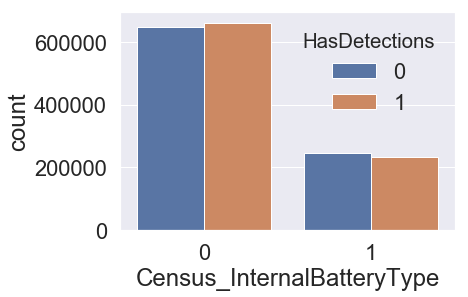

In [33]:
sns.countplot(x='Census_InternalBatteryType', hue='HasDetections',data=train_small)
plt.show()

違いはかなり小さいです。あなたはいくつかのマルウェアがバッテリーのタイプに基づいてマシンを認識して選択すると思いますか？

バッテリーは機械の寿命にとって非常に重要な部分です。マルウェアは、マシンの他のハードウェアおよびソフトウェア部分に集中すると思います。

これを削除してください。

### 少しだけEDA

In [34]:
# Categorical features
categorical_features = [
        'ProductName',                                          
        'EngineVersion',                                        
        'AppVersion',                                           
        'AvSigVersion',                                         
        'Platform',                                             
        'Processor',                                            
        'OsVer',                                                
        'OsPlatformSubRelease',                                 
        'OsBuildLab',                                           
        'SkuEdition',                                           
        'SmartScreen',                                          
        'Census_MDC2FormFactor',                                
        'Census_DeviceFamily',                                  
        'Census_PrimaryDiskTypeName',                           
        'Census_ChassisTypeName',                               
        'Census_PowerPlatformRoleName',                         
        'Census_OSVersion',                                     
        'Census_OSArchitecture',                                
        'Census_OSBranch',                                      
        'Census_OSEdition',                                     
        'Census_OSSkuName',                                     
        'Census_OSInstallTypeName',                             
        'Census_OSWUAutoUpdateOptionsName',                     
        'Census_GenuineStateName',                              
        'Census_ActivationChannel',                             
        'Census_FlightRing',                                    
]

In [35]:
#ProductName - 防御側の状態情報
def plot_category_percent_of_target(col):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cat_percent = train_small[[col, 'HasDetections']].groupby(col, as_index=False).mean()
    cat_size = train_small[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['HasDetections'] = cat_percent['HasDetections'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='HasDetections', y=col, data=cat_percent, order=cat_percent[col])

    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    plt.xlabel('% of HasDetections(target)')
    plt.ylabel(col)
    plt.show()

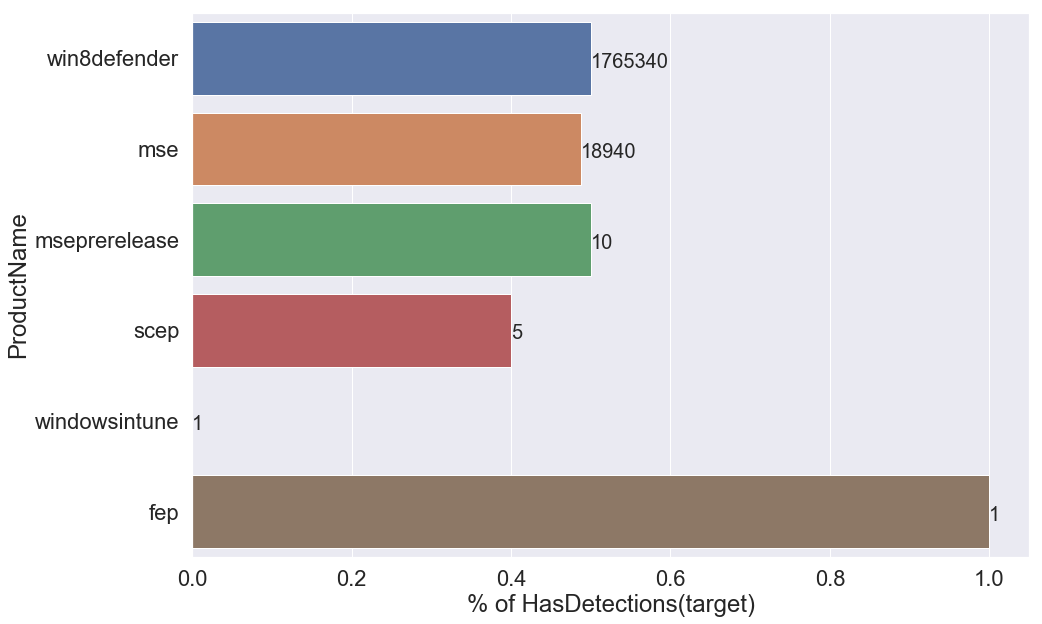

In [36]:
col = categorical_features[0]
plot_category_percent_of_target(col)

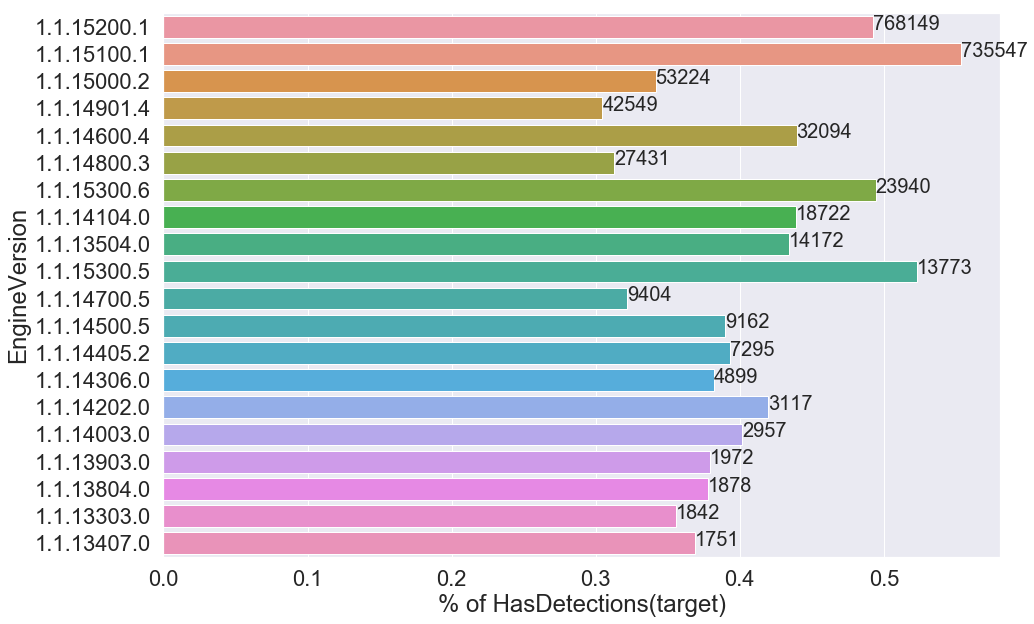

In [37]:
col = categorical_features[1]
plot_category_percent_of_target(col)

よくわからない
バージョンが古いほど感染率が低い傾向がある。　これはバージョンが古い人はパソコンの使用頻度が低いので感染しにくいのでは

In [44]:
numeric_features = [
        'IsBeta',                                               
        'RtpStateBitfield',                                     
        'IsSxsPassiveMode',                                     
        'DefaultBrowsersIdentifier',                            
        'AVProductStatesIdentifier',                            
        'AVProductsInstalled',                                  
        'AVProductsEnabled',                                    
        'HasTpm',                                               
        'CountryIdentifier',                                    
        'CityIdentifier',                                       
        'OrganizationIdentifier',                               
        'GeoNameIdentifier',                                    
        'LocaleEnglishNameIdentifier',                          
        'OsBuild',                                              
        'OsSuite',                                              
        'IsProtected',                                          
        'AutoSampleOptIn',                                      
        'SMode',                                                
        'IeVerIdentifier',                                      
        'Firewall',                                             
        'UacLuaenable',                                         
        'Census_OEMNameIdentifier',                             
        'Census_OEMModelIdentifier',                            
        'Census_ProcessorCoreCount',                            
        'Census_ProcessorManufacturerIdentifier',               
        'Census_ProcessorModelIdentifier',                      
        'Census_PrimaryDiskTotalCapacity',                      
        'Census_SystemVolumeTotalCapacity',                     
        'Census_HasOpticalDiskDrive',                           
        'Census_TotalPhysicalRAM',                              
        'Census_InternalPrimaryDiagonalDisplaySizeInInches',    
        'Census_InternalPrimaryDisplayResolutionHorizontal',    
        'Census_InternalPrimaryDisplayResolutionVertical',      
        'Census_InternalBatteryNumberOfCharges',                
        'Census_OSBuildNumber',                                 
        'Census_OSBuildRevision',                               
        'Census_OSInstallLanguageIdentifier',                   
        'Census_OSUILocaleIdentifier',                          
        'Census_IsPortableOperatingSystem',                     
        'Census_IsFlightsDisabled',                             
        'Census_ThresholdOptIn',                                
        'Census_FirmwareManufacturerIdentifier',                
        'Census_FirmwareVersionIdentifier',                     
        'Census_IsSecureBootEnabled',                           
        'Census_IsWIMBootEnabled',                              
        'Census_IsVirtualDevice',                               
        'Census_IsTouchEnabled',                                
        'Census_IsPenCapable',                                  
        'Census_IsAlwaysOnAlwaysConnectedCapable',              
        'Wdft_IsGamer',                                         
        'Wdft_RegionIdentifier',                                
]

## 3. Correlations

In [46]:
def corr_heatmap(cols):
    correlations = train_small[cols+['HasDetections']].corr()
    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()

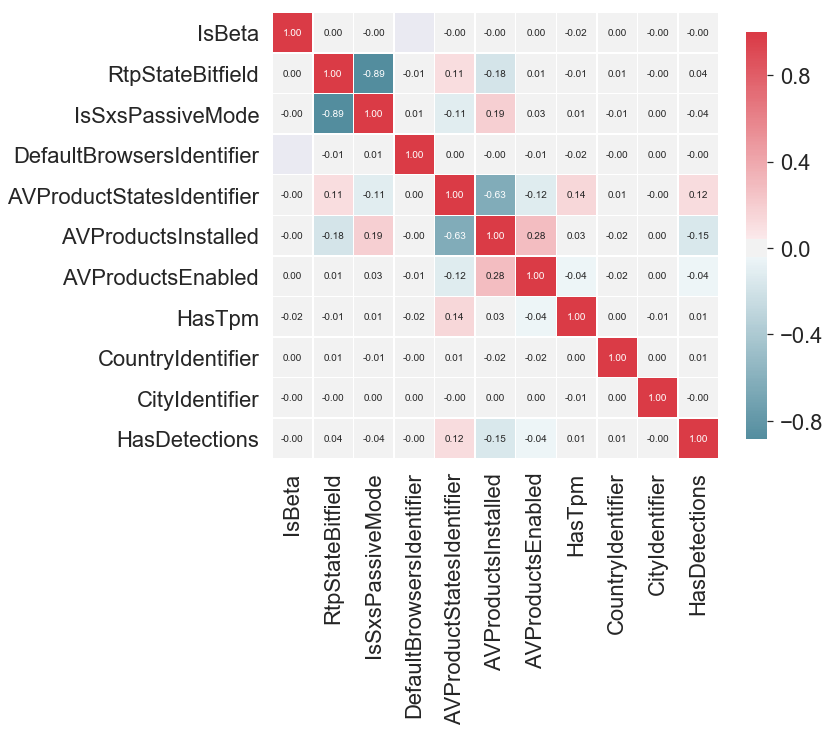

In [47]:
corr_heatmap(numeric_features[:10])

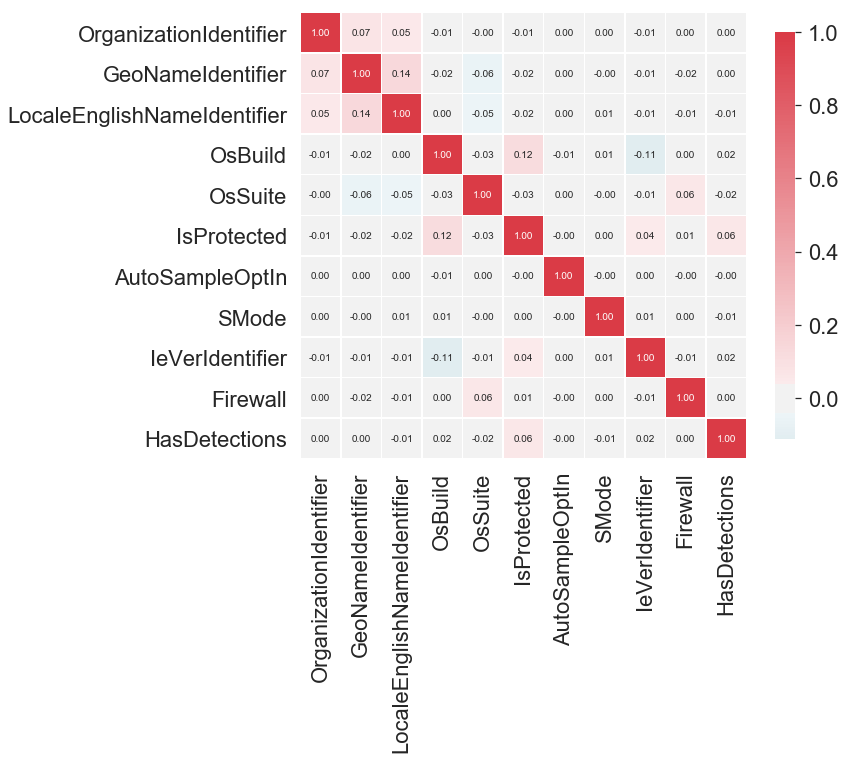

In [48]:
corr_heatmap(numeric_features[10:20])

# 3.問題3
コーディング

単一モデルで学習して推定を行ってください。また、交差検証、グリッドサーチも行うこと。

ここで1つSubmitを行ってください。（現在開催中のコンペであり、1日の提出回数に制限があることに注意してください。）

In [50]:
train_small.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
2168155,3e36a0dcce5bc6264a7b46d36912378e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1283.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,99,72125.0,27.0,127.0,67,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,117.0,ExistsNotSet,1.0,1.0,Notebook,Windows.Desktop,585.0,189470.0,4.0,5.0,2660.0,NaN,244198.0,SSD,243227.0,0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,1,0.0,10.0.16299.371,amd64,rs3_release,16299,371,Core,CORE,UUPUpgrade,8.0,31,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,556.0,63086.0,1,0.0,0.0,0,0,0.0,0.0,10.0,1
6573702,bca9de3acc782ed77d7145114c618088,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,5189.0,NaN,35.0,-85,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,0.0,117.0,ExistsNotSet,1.0,1.0,Notebook,Windows.Desktop,2668.0,171278.0,4.0,5.0,3026.0,NaN,953869.0,HDD,906850.0,0,8192.0,Notebook,15.500000,1366.0,768.0,Mobile,0,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,CoreSingleLanguage,CORE_SINGLELANGUAGE,Reset,26.0,119,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,628.0,27266.0,1,NaN,0.0,0,0,0.0,0.0,10.0,1
4791823,8986215014af1a21c468c0a25df6ad55,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1001.0,0,7.0,0,NaN,52365.0,2.0,1.0,1,177,87729.0,NaN,251.0,-17,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,261048.0,4.0,5.0,2536.0,NaN,476940.0,HDD,428121.0,0,4096.0,Notebook,13.203125,1366.0,768.0,Mobile,1,0.0,10.0.17134.228,amd64,rs4_release,17134,228,Core,CORE,Upgrade,33.0,140,FullAuto,0,IS_GENUINE,Retail,0.0,0.0,Unknown,0.0,628.0,14130.0,1,0.0,0.0,0,0,0.0,0.0,15.0,0
5715233,a40bc9b6a3af46a93743254bd1298dd0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.810.0,0,7.0,0,NaN,47238.0,2.0,1.0,1,207,115788.0,27.0,277.0,75,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,171477.0,2.0,5.0,2096.0,NaN,953869.0,HDD,926992.0,0,4096.0,Notebook,15.500000,1366.0,768.0,Mobi

In [98]:
TARGET = "HasDetections"

In [109]:
f_list = ["Platform", "SmartScreen", "Wdft_IsGamer", "HasDetections"]
t_list = ["Platform", "SmartScreen", "Wdft_IsGamer"]

In [104]:
train_small2 = train_small[f_list]

In [312]:
#変換の前にテストデータとくっつける
df_train_test = train_small2.append(test[t_list])
df_train_test2 = pd.get_dummies(df_train_test, dummy_na=True)
df_train_test2 = df_train_test2.fillna({"Wdft_IsGamer":0})

In [322]:
#分ける
train_small3 = df_train_test2.iloc[:train_small2.shape[0], :]
test_small = df_train_test2.iloc[train_small2.shape[0]:, :]
test_small = test_small.drop("HasDetections", axis=1)

In [367]:
X = train_small3.drop(TARGET, axis=1).values
y = train_small3[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [330]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [349]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [364]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [370]:
#グリッドサーチ

model = LogisticRegression()

tuned_parameters = {'C': [1, 10, 100, 1000]}

clf = GridSearchCV(
    model, # 識別器
    tuned_parameters, # 最適化したいパラメータセット 
    cv=3, # 交差検定の回数
    ) # モデルの評価関数の指定

clf.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [371]:
clf.best_params_

{'C': 1}

In [395]:
model = LogisticRegression(C=1)
model.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [397]:
y_pred = model.predict(X_test)

In [408]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [409]:
auc

0.5816730472215393

In [410]:
y_pred = model.predict(test_small)

In [411]:
submit = pd.read_csv("/Users/morio/diveintocode-ml/input/microsoft/sample_submission.csv")

In [412]:
submit[TARGET] = y_pred

In [416]:
submit.to_csv("/Users/morio/diveintocode-ml/input/microsoft/sub1.csv", index=False)

# submit 0.554

# 問題４
バギング

バギングにはSoft VotingとHard Votingがあります。それぞれについて説明してください。

### 1つの方法として、データ全てを使うのではなくその一部を使って学習し、それを何度も繰り返して最後に合わせる方法が考えられる。それがバギングである。soft voting : 各モデルの予測確率の平均を取ります。hard voting : 単純に多数決です。10個のモデルのうち7つがA、3つがBって言ったらAを予測結果として返します。

バギングする際に選ぶモデルはどういった組み合わせにすると良いか考察してください。今後アンサンブル学習を利用していく上で非常に重要な点です。

 ### 似たようなモデルを選ばないこと。それぞれのモデルがデータの違う側面を捉えているようなものが望ましい。


ブースティング

バギングとの違いについて説明してください。

### データの一部を抽出してそれで弱学習機を作り、最後に合わせるのはバギングと同様。違いは前回の結果を利用するのがブースティング。なので並列処理はできない。Boostingとは、弱学習器をboostして、そのアルゴリズムよりも強い学習アルゴリズムをつくることです．ブースティングの一般的な考え方は、学習器を連続的に学習させて、より精度が向上するように修正していくことです。



In [418]:
#バギング
svm =SVC(C=5, gamma=0.001, probability=True)

In [417]:
from sklearn.ensemble import VotingClassifier

In [420]:
vc_soft = VotingClassifier(estimators=[("svm", svm), ("lg", model)], voting='soft')

In [ ]:
vc_soft.fit(X_train, y_train)

In [ ]:
y_pred = vc_soft.predict(X_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [ ]:
auc

In [ ]:
#ブースティング
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    #lgbmでモデル作成
lgb_params = {'objective':'binary', 
                 'boosting_type': 'rf',
                 'subsample': 0.623,
                  'colsample_bytree': 0.7,
                  'num_leaves': 127,
                  'max_depth': 8,
                  'seed': 99,
                  'bagging_freq': 1,
                  'n_jobs': 4,}
                                
model_lgb = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)
y_pred = model_lgb.predict(X_test)
    

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [ ]:
auc

# 問題６

仮説：　国によって変わる。　→　結論フィルターをONにする広報活動

→　ファイルやアプリのダウンロードの際、フィルターをかけるかどうか？

マルウェア感染率の高い国と低い国を比べて「SmartScreen」ごとの感染率をみる

感染率高い国　香港
低い国　インド

smartscreenの設定は三つある

RequireAdmin 一番強いフィルダー　管理者権限が必要
Warm 　ダウンロードなどの際に警告がでる
Off   フィルタなし


smartscreenはカテゴリデータでユニークな値が２０ほどあるので、上の三つの設定に統合する

In [230]:
df_h_re = pd.DataFrame(train['SmartScreen'].value_counts())

In [232]:
df_h_re["mean"] =train[ train['HasDetections'] == 1]["SmartScreen"].value_counts() / train["SmartScreen"].value_counts()

In [235]:
df_ind = train.loc[train['CountryIdentifier']== 113, :]

In [250]:
df_ind.loc[df_ind["SmartScreen"] == "ExistsNotSet", "SmartScreen"] = "Off"
df_ind.loc[df_ind["SmartScreen"] == "Prompt", "SmartScreen"] = "Warn"
df_ind.loc[df_ind["SmartScreen"] == "Block", "SmartScreen"] = "Warn"

In [253]:
df_ind_re = pd.DataFrame(df_ind[df_ind[TARGET] == 1]["SmartScreen"].value_counts() / df_ind["SmartScreen"].value_counts())

In [254]:
df_ind_re["count"] = df_ind["SmartScreen"].value_counts()

In [301]:
df_ind_re = df_ind_re.rename(columns={'SmartScreen': 'SmartScreen_kansenritu'})

In [258]:
df_Hongkong = train.loc[train['CountryIdentifier']==104, :]

In [264]:
df_Hongkong.loc[df_Hongkong["SmartScreen"] == "ExistsNotSet", "SmartScreen"] = "Off"
df_Hongkong.loc[df_Hongkong["SmartScreen"] == "Prompt", "SmartScreen"] = "Warn"
df_Hongkong.loc[df_Hongkong["SmartScreen"] == "Block", "SmartScreen"] = "Warn"
df_Hongkong.loc[df_Hongkong["SmartScreen"] == "off", "SmartScreen"] = "Off"
df_Hongkong.loc[df_Hongkong["SmartScreen"] == "&#x02;", "SmartScreen"] = "Off"
df_Hongkong.loc[df_Hongkong["SmartScreen"] ==  "&#x01;", "SmartScreen"] = "Off"

In [266]:
df_hong_re = pd.DataFrame(df_Hongkong[df_Hongkong[TARGET] == 1]["SmartScreen"].value_counts() / df_Hongkong["SmartScreen"].value_counts())

In [267]:
df_hong_re["count"] = df_Hongkong["SmartScreen"].value_counts()

In [300]:
df_hong_re = df_hong_re.rename(columns={'SmartScreen': 'SmartScreen_kansenritu'})

In [292]:
df_ind_re["index_par"] = df_ind_re["count"] / df_ind_re["count"].sum()

In [290]:
df_hong_re["index_par"] = df_hong_re["count"] / df_hong_re["count"].sum()

In [305]:
df_ind_re.sort_values("SmartScreen_kansenritu", ascending=False).iloc[:3,:]
#インドの感染率　0.442

,SmartScreen_kansenritu,count,index_par
Off,0.780335,478,0.186646
Warn,0.454545,66,0.025771
RequireAdmin,0.372335,2017,0.787583


In [306]:
df_hong_re.sort_values("SmartScreen_kansenritu", ascending=False).iloc[:3,:]
#香港の感染率　0.640

,SmartScreen_kansenritu,count,index_par
Off,0.793455,7548,0.458566
Warn,0.605882,510,0.030984
RequireAdmin,0.528684,8402,0.510450


### 感染率が低いインドはoffの割合が低い、　感染率が高い香港は、offの割合が高い

### 結論　フィルターをonにする広報活動をお勧めします